## Fiz com python 2

In [1]:

print (__doc__)

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

from sklearn.cross_validation import train_test_split

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Automatically created module for IPython interactive environment


In [2]:

###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

2018-05-26 12:27:53,002 Loading LFW people faces from /home/ralph/scikit_learn_data/lfw_home


In [3]:

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)


In [4]:
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print ("Total dataset size:")
print ("n_samples: %d" % n_samples)
print ("n_features: %d" % n_features)
print ("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [5]:
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print ("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print ("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print ("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 1.167s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.061s


In [16]:
pca.explained_variance_ratio_

array([ 0.19409108,  0.15479642,  0.07222181,  0.05789208,  0.0500485 ,
        0.02923378,  0.02583819,  0.02074249,  0.02046022,  0.01848388,
        0.01643746,  0.01479799,  0.01226293,  0.01073282,  0.01048607,
        0.0100285 ,  0.00917218,  0.00869244,  0.00815734,  0.0071474 ,
        0.00688163,  0.00657809,  0.00616965,  0.00585356,  0.00554223,
        0.00541484,  0.0049938 ,  0.00456373,  0.00442006,  0.00412872,
        0.00374271,  0.00368478,  0.00358351,  0.00344214,  0.00336376,
        0.00322566,  0.00316267,  0.00302462,  0.0029377 ,  0.00285619,
        0.00284717,  0.00268579,  0.00259516,  0.00248156,  0.00241645,
        0.00235644,  0.00230122,  0.00225978,  0.00222743,  0.00213668,
        0.00206742,  0.00204259,  0.00196118,  0.00190612,  0.00188403,
        0.00184526,  0.00180723,  0.00177874,  0.00175247,  0.00167289,
        0.00162465,  0.00158225,  0.00155867,  0.00153206,  0.00145446,
        0.00145013,  0.00141685,  0.00141095,  0.00136388,  0.00

In [7]:
# Train a SVM classification model

print ("Fitting the classifier to the training set")
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print ("done in %0.3fs" % (time() - t0))
print ("Best estimator found by grid search:")
print (clf.best_estimator_)

Fitting the classifier to the training set
done in 27.277s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [8]:
# Quantitative evaluation of the model quality on the test set

print ("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print ("done in %0.3fs" % (time() - t0))

print (classification_report(y_test, y_pred, target_names=target_names))
print (confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting the people names on the testing set
done in 0.115s
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.62      0.73        13
     Colin Powell       0.87      0.90      0.89        60
  Donald Rumsfeld       0.86      0.67      0.75        27
    George W Bush       0.83      0.97      0.89       146
Gerhard Schroeder       0.90      0.76      0.83        25
      Hugo Chavez       1.00      0.67      0.80        15
       Tony Blair       0.97      0.78      0.86        36

      avg / total       0.87      0.86      0.86       322

[[  8   0   0   5   0   0   0]
 [  1  54   1   4   0   0   0]
 [  0   1  18   7   1   0   0]
 [  0   4   1 141   0   0   0]
 [  0   1   1   4  19   0   0]
 [  0   1   0   3   0  10   1]
 [  0   1   0   6   1   0  28]]


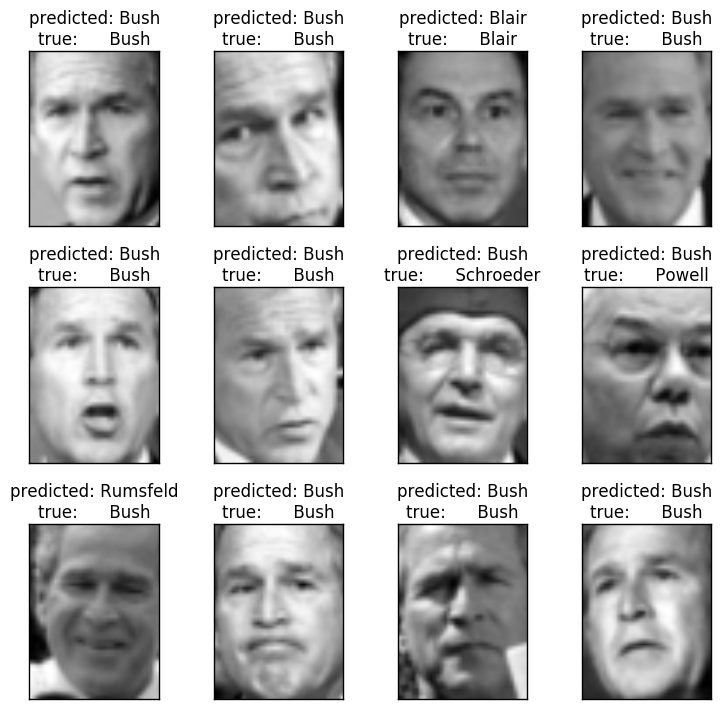

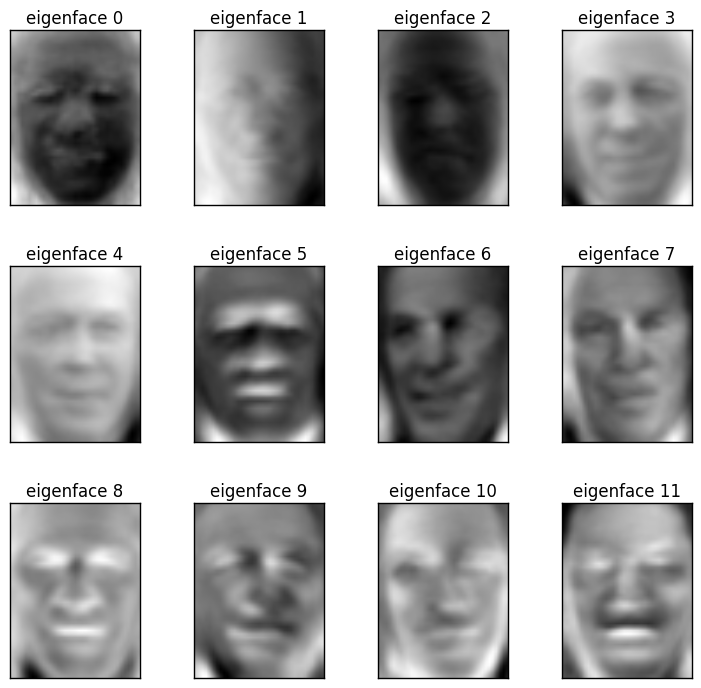

In [9]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

## Mudado os n componests to [10, 15, 25, 50, 100, 250].

Extracting the top 250 eigenfaces from 966 faces
done in 0.537s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.066s
Fitting the classifier to the training set
done in 43.690s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.125s
                   precision    recall  f1-score   support

     Ariel Sharon       0.58      0.85      0.69        13
     Colin Powell       0.80      0.88      0.84        60
  Donald Rumsfeld       0.71      0.63      0.67        27
    George W Bush       0.85      0.86      0.86       146
Gerhard Schroeder       0.79      0.76      0.78        25
      Hugo Chavez       0.86      0.40      0.55        15
       Tony Blair       0.82      0.78      0.80      

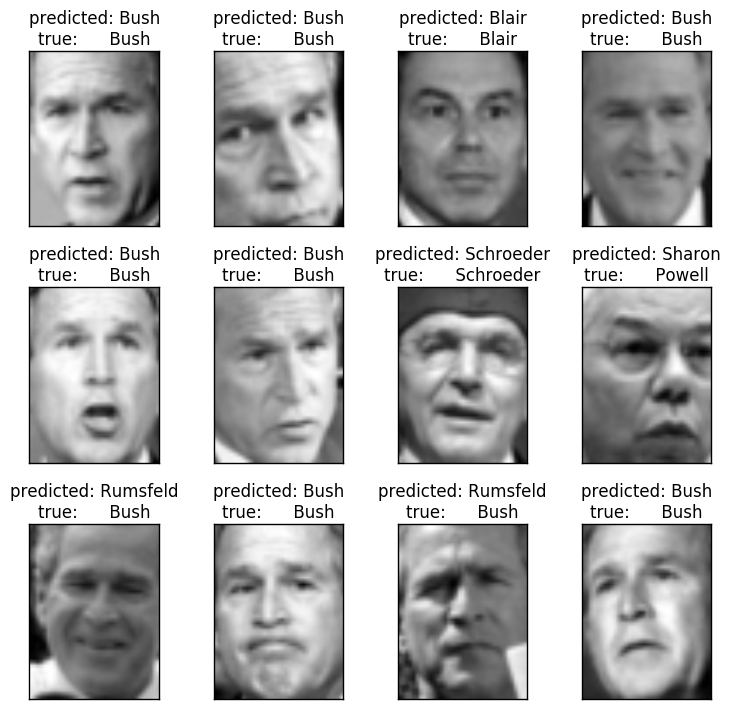

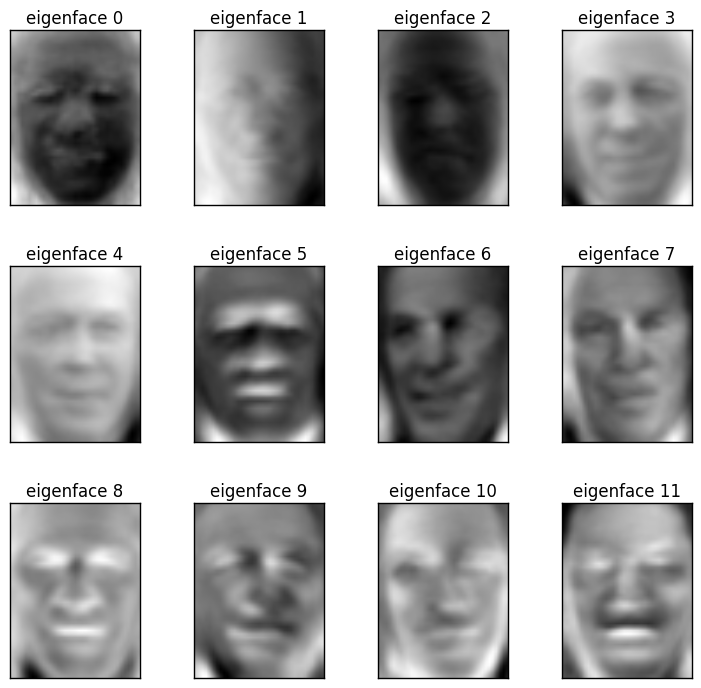

In [19]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
#n_components = 150
n_components = 250

print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print ("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print ("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print ("done in %0.3fs" % (time() - t0))


# Train a SVM classification model

print ("Fitting the classifier to the training set")
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print ("done in %0.3fs" % (time() - t0))
print ("Best estimator found by grid search:")
print (clf.best_estimator_)


print ("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print ("done in %0.3fs" % (time() - t0))

print (classification_report(y_test, y_pred, target_names=target_names))
print (confusion_matrix(y_test, y_pred, labels=range(n_classes)))

# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

                 precision    recall  f1-score   support

     Ariel Sharon       0.40      0.46      0.43        13
     Colin Powell       0.54      0.65      0.59        60
     Donald Rumsfeld    0.52      0.48      0.50        27
     George W Bush      0.74      0.73      0.74       146
     Gerhard Schroeder  0.44      0.28      0.34        25
     Hugo Chavez        0.78      0.47      0.58        15
     Tony Blair         0.55      0.61      0.58        36

      avg / total       0.63      0.62      0.62       322

[[  6   4   2   0   1   0   0]
 [  9  39   1  10   1   0   0]
 [  0   5  13   6   1   0   2]
 [  0  20   7 107   2   2   8]
 [  0   2   0   9   7   0   7]
 [  0   1   0   5   1   7   1]
 [  0   1   2   8   3   0  22]]